In [1]:
import torch
import torchvision

# Loading MNIST data

In [5]:
#define hyperparameters for model training
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 100
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [7]:
#load MNIST data
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,)
        )
    ])),
    batch_size=batch_size_train, shuffle=True)



In [9]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])), batch_size=batch_size_test, shuffle=True)

In [13]:
#Looking at hadwritten examples
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [14]:
#shape of one batch size
example_data.shape

torch.Size([1000, 1, 28, 28])

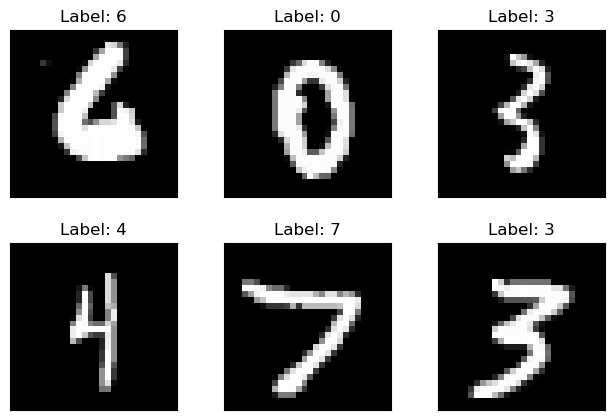

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title('Label: {}'.format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# Building the CNN

In [17]:
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() 
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [20]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum=momentum)

In [25]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

In [34]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [26]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [35]:
test()
for epoch in range(1, n_epochs+1):
    train(epoch)
    test()

/var/folders/9t/ywq9gg3s4zbgn2zw5tfskbv00000gn/T/ipykernel_66225/410077737.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/opt/anaconda3/envs/MSCI623/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3074, Accuracy: 918/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302089
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.305638
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.332145
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.272092
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.308137
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.245898
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.229880
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.237232
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.174164
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.125534
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.148961
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.934557
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.825862
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.783877
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.632262
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.696360
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.486752
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.480923
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.188753
Train Epoch: 1 [12160/6

ValueError: x and y must be the same size

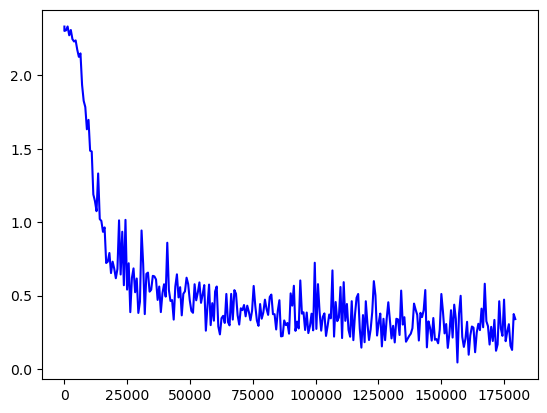

In [39]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')

In [40]:
with torch.no_grad():
    output = network(example_data)

/var/folders/9t/ywq9gg3s4zbgn2zw5tfskbv00000gn/T/ipykernel_66225/410077737.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


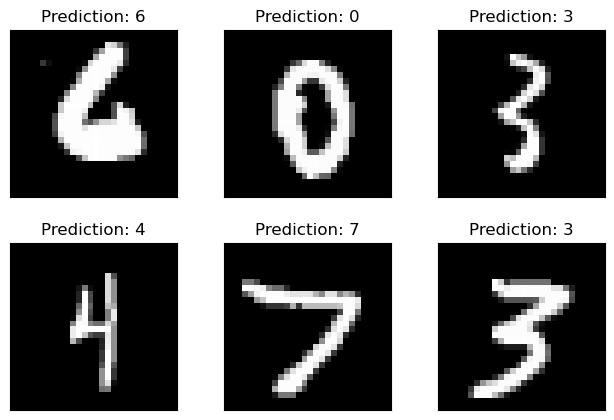

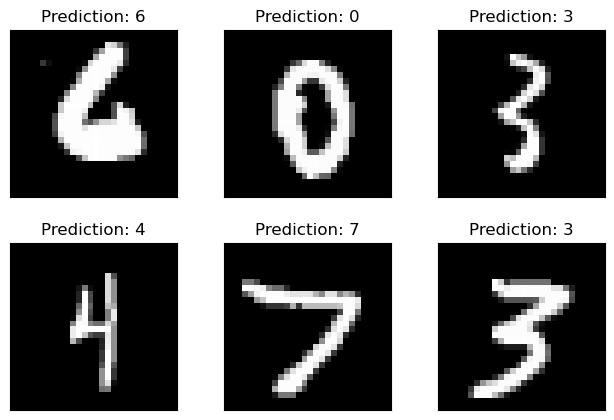

In [41]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

# Continue training from saved states

In [43]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum=momentum)

In [44]:
#load the network states to continue training
network_state_dict = torch.load('./results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('./results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for i in range(4, 9):
    test_counter.append(i * len(train_loader.dataset))
    train(i)
    test()